## 5. Деревья решений 

**Дерево решений (Decision Tree)** — алгоритм машинного обучения, который строит иерархию if-then правил для классификации или регрессии. Дерево состоит из узлов (вопросы-разбиения), рёбер (ответы да/нет) и листьев (предсказания).

**Корень дерева (Root Node)** — начальный узел, содержащий все данные. Выбирается признак, который лучше всего разделяет классы.

**Узел (Internal Node)** — промежуточная точка дерева, где происходит разбиение по условию (например, "Age > 50?").

**Лист (Leaf Node)** — конечный узел, содержащий предсказание (класс для классификации, число для регрессии).

**Разбиение (Split)** — выбор признака и порога для деления данных на две группы. Критерии качества разбиения: Gini impurity, entropy (information gain), MSE (для регрессии).

**Gini Impurity** — мера "нечистоты" узла. Gini = 0 → все объекты одного класса (идеальное разбиение). Gini = 0.5 → классы распределены равномерно (плохое разбиение). Формула: `Gini = 1 - Σ(p_i²)`, где p_i — доля класса i.

**Энтропия (Entropy)** — мера неопределённости. Entropy = 0 → один класс, entropy максимальна → все классы равновероятны. Формула: `H = -Σ(p_i × log₂(p_i))`.

**Information Gain** — уменьшение энтропии после разбиения. Чем больше information gain, тем лучше разбиение.

**Переобучение деревьев (Overfitting)** — дерево запоминает шум в обучающих данных, создавая слишком сложные правила. Результат: accuracy=100% на train, но низкая на test.

**Гиперпараметры деревьев:**
- **max_depth** — максимальная глубина дерева (количество уровней). Ограничивает сложность.
- **min_samples_split** — минимальное количество объектов для разбиения узла.
- **min_samples_leaf** — минимальное количество объектов в листе.
- **max_features** — количество признаков для рассмотрения при каждом разбиении.

**Random Forest** — ансамбль (комбинация) многих деревьев решений. Каждое дерево обучается на случайной подвыборке данных (bagging) с случайным набором признаков. Финальное предсказание — голосование (классификация) или среднее (регрессия).

**Bagging (Bootstrap Aggregating)** — техника создания ансамбля: генерируем N случайных подвыборок с возвратом (bootstrap samples), обучаем модель на каждой, агрегируем предсказания.

**Feature Importance** — мера важности признака для модели. Вычисляется как суммарное уменьшение Gini impurity (или MSE) при разбиениях по этому признаку. Чем больше важность, тем сильнее признак влияет на предсказания.

**Out-of-Bag (OOB) Error** — оценка ошибки Random Forest без отдельной тестовой выборки. Каждое дерево обучается на ~63% данных (bootstrap), остальные 37% используются для валидации этого дерева.

**Bias-Variance Tradeoff для деревьев:**
- **Неглубокое дерево** (max_depth=3): high bias (недообучение), low variance → стабильные, но неточные предсказания
- **Глубокое дерево** (max_depth=None): low bias, high variance → точные на train, нестабильные на test
- **Random Forest**: low bias, low variance (за счёт усреднения) → best of both worlds

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, 
                              confusion_matrix, ConfusionMatrixDisplay)

sns.set_theme(style="whitegrid", palette="Set2", font_scale=1.1)

# Загрузка Heart Disease UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
df = pd.read_csv(url, names=columns, na_values='?')

# target: 0 = нет болезни, 1-4 = есть болезнь → бинаризуем
df['target'] = (df['target'] > 0).astype(int)

print(f"Датасет Heart Disease: {df.shape[0]} строк × {df.shape[1]} столбцов")
print(f"Целевая переменная: target (0 = здоров, 1 = болезнь сердца)")

Датасет Heart Disease: 303 строк × 14 столбцов
Целевая переменная: target (0 = здоров, 1 = болезнь сердца)


In [2]:
df.head()
df.info()
print("\nБаланс классов:")
print(df['target'].value_counts())
print(f"Процент больных: {df['target'].mean()*100:.1f}%")

# Пропуски
print("\nПропущенные значения:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Удалим строки с пропусками (их немного)
df_clean = df.dropna()
print(f"\nПосле удаления пропусков: {df_clean.shape[0]} строк")

# Подготовка X и y
X = df_clean.drop('target', axis=1)
y = df_clean['target']

print("\nПризнаки (упрощённые названия):")
feature_descriptions = {
    'age': 'Возраст',
    'sex': 'Пол (1=М, 0=Ж)',
    'cp': 'Тип боли в груди',
    'trestbps': 'Давление в покое',
    'chol': 'Холестерин',
    'fbs': 'Сахар натощак > 120',
    'restecg': 'ЭКГ в покое',
    'thalach': 'Макс. ЧСС',
    'exang': 'Стенокардия при нагрузке',
    'oldpeak': 'ST-депрессия',
    'slope': 'Наклон ST-сегмента',
    'ca': 'Количество сосудов (флюоро)',
    'thal': 'Таллий-сканирование'
}
for col, desc in feature_descriptions.items():
    print(f"  {col:10s}: {desc}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int32  
dtypes: float64(13), int32(1)
memory usage: 32.1 KB

Баланс классов:
0    164
1    139
Name: target, dtype: int64
Процент больных: 45.9%

Пропущенные значения:
ca      4
thal    2
dtype: int64

После удаления пропусков: 297 строк

Признаки (упрощённые названия):
  age   

In [3]:
# TODO: разделите на train/test (70/30, stratify, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")
print(f"Баланс в train: {np.bincount(y_train)}")
print(f"Баланс в test:  {np.bincount(y_test)}")

Train: 267 samples
Test:  30 samples
Баланс в train: [144 123]
Баланс в test:  [16 14]


**Обучение простого дерева**
Плюсы : Деревья работают с "сырыми" данными (не нужно масштабирование, не нужно one-hot encoding ). 
Понятность: Можно буквально распечатать картинку дерева и понять, почему модель приняла решение.	

Минусы: Переобучение: Без ограничений дерево «зазубрит» тренировочные данные до идеала, но провалится на новых.
Нестабильность: Малейшее изменение в данных может полностью перестроить всю структуру дерева.

Ключевые настройки (Гиперпараметры)
Чтобы дерево не стало слишком сложным (не переобучилось), его нужно «подрезать»:
max_depth: Максимальная глубина (сколько вопросов можно задать). Если не ограничить, дерево может вырасти до бесконечности.
min_samples_split: Сколько примеров должно быть в узле, чтобы его можно было делить дальше.

In [5]:
tree_simple = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_simple.fit(X_train, y_train)

# Предсказания
y_pred_simple = tree_simple.predict(X_test)
acc_simple = accuracy_score(y_test, y_pred_simple)

print(f"Decision Tree (max_depth=3):")
print(f"  Train accuracy: {tree_simple.score(X_train, y_train):.4f}")
print(f"  Test accuracy:  {acc_simple:.4f}")
print(f"\nКоличество листьев: {tree_simple.get_n_leaves()}")
print(f"Глубина дерева: {tree_simple.get_depth()}")

Decision Tree (max_depth=3):
  Train accuracy: 0.8652
  Test accuracy:  0.7667

Количество листьев: 8
Глубина дерева: 3


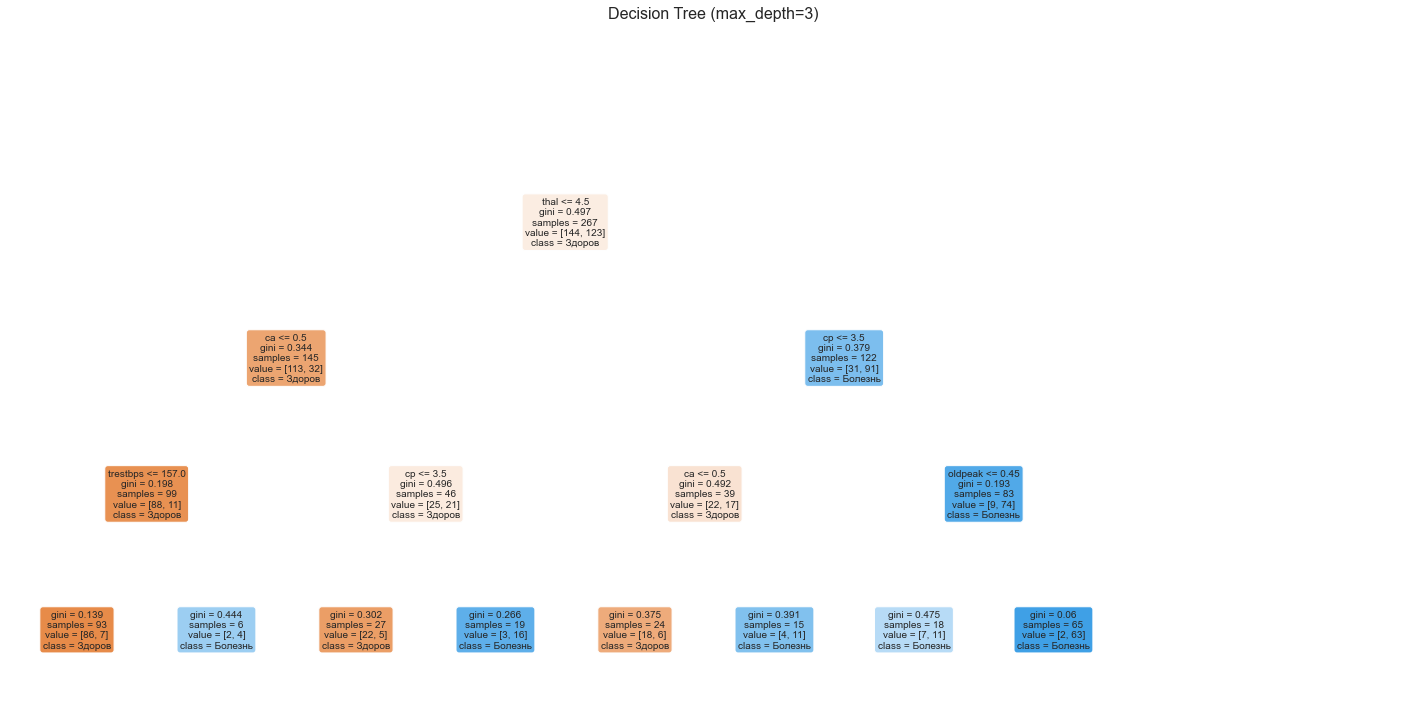

Верхняя строка: условие разбиения (например, 'thal <= 2.5')
gini: мера нечистоты (0 = все объекты одного класса)
samples: количество объектов в узле
value: [здоровые, больные] в узле
class: предсказанный класс (по большинству)


In [7]:
# Визуализация дерева
plt.figure(figsize=(20, 10))
plot_tree(tree_simple, 
          feature_names=X.columns, 
          class_names=['Здоров', 'Болезнь'],
          filled=True,           # Раскрасить узлы по классу
          rounded=True,          # Скруглённые углы
          fontsize=10)
plt.title('Decision Tree (max_depth=3)', fontsize=16)
plt.tight_layout()
plt.show()

print("Верхняя строка: условие разбиения (например, 'thal <= 2.5')")
print("gini: мера нечистоты (0 = все объекты одного класса)")
print("samples: количество объектов в узле")
print("value: [здоровые, больные] в узле")
print("class: предсказанный класс (по большинству)")

In [8]:
# Текстовый вывод дерева (для копирования правил)
tree_rules = export_text(tree_simple, feature_names=list(X.columns))
print("Правила дерева в текстовом формате:")
print(tree_rules)

print("\nПример правила:")
print("Если thal <= 2.5 И ca <= 0.5 → класс 0 (Здоров)")
print("Это читается как: Если таллий-тест ≤ 2.5 И число сосудов ≤ 0.5 → низкий риск")

Правила дерева в текстовом формате:
|--- thal <= 4.50
|   |--- ca <= 0.50
|   |   |--- trestbps <= 157.00
|   |   |   |--- class: 0
|   |   |--- trestbps >  157.00
|   |   |   |--- class: 1
|   |--- ca >  0.50
|   |   |--- cp <= 3.50
|   |   |   |--- class: 0
|   |   |--- cp >  3.50
|   |   |   |--- class: 1
|--- thal >  4.50
|   |--- cp <= 3.50
|   |   |--- ca <= 0.50
|   |   |   |--- class: 0
|   |   |--- ca >  0.50
|   |   |   |--- class: 1
|   |--- cp >  3.50
|   |   |--- oldpeak <= 0.45
|   |   |   |--- class: 1
|   |   |--- oldpeak >  0.45
|   |   |   |--- class: 1


Пример правила:
Если thal <= 2.5 И ca <= 0.5 → класс 0 (Здоров)
Это читается как: Если таллий-тест ≤ 2.5 И число сосудов ≤ 0.5 → низкий риск


Важность признаков (топ-5):
  Feature  Importance
     thal    0.477426
       cp    0.269634
       ca    0.154217
 trestbps    0.051497
  oldpeak    0.047226


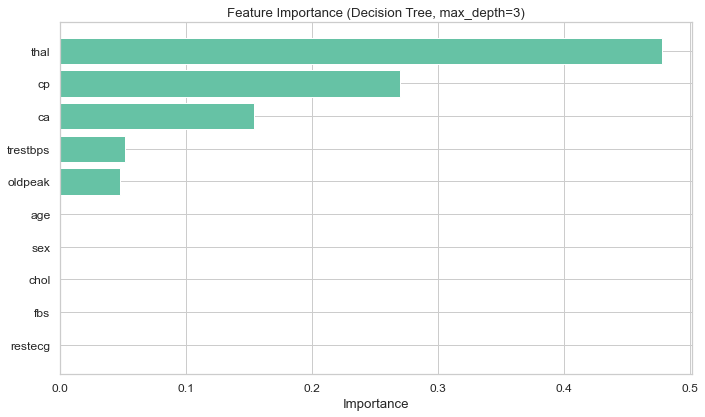

In [9]:
importances = tree_simple.feature_importances_
feature_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("Важность признаков (топ-5):")
print(feature_imp_df.head().to_string(index=False))

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(feature_imp_df['Feature'][:10], feature_imp_df['Importance'][:10])
plt.xlabel('Importance')
plt.title('Feature Importance (Decision Tree, max_depth=3)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [10]:
# Обучаем дерево БЕЗ ограничения глубины
tree_deep = DecisionTreeClassifier(random_state=42)  # max_depth=None по умолчанию
tree_deep.fit(X_train, y_train)

# Предсказания
y_pred_deep = tree_deep.predict(X_test)
acc_deep = accuracy_score(y_test, y_pred_deep)

print(f"Decision Tree (без ограничений):")
print(f"  Train accuracy: {tree_deep.score(X_train, y_train):.4f}")
print(f"  Test accuracy:  {acc_deep:.4f}")
print(f"\nКоличество листьев: {tree_deep.get_n_leaves()}")
print(f"Глубина дерева: {tree_deep.get_depth()}")
print(f"\n Train = 100% Это ПЕРЕОБУЧЕНИЕ!")

Decision Tree (без ограничений):
  Train accuracy: 1.0000
  Test accuracy:  0.6667

Количество листьев: 47
Глубина дерева: 9

 Train = 100% Это ПЕРЕОБУЧЕНИЕ!


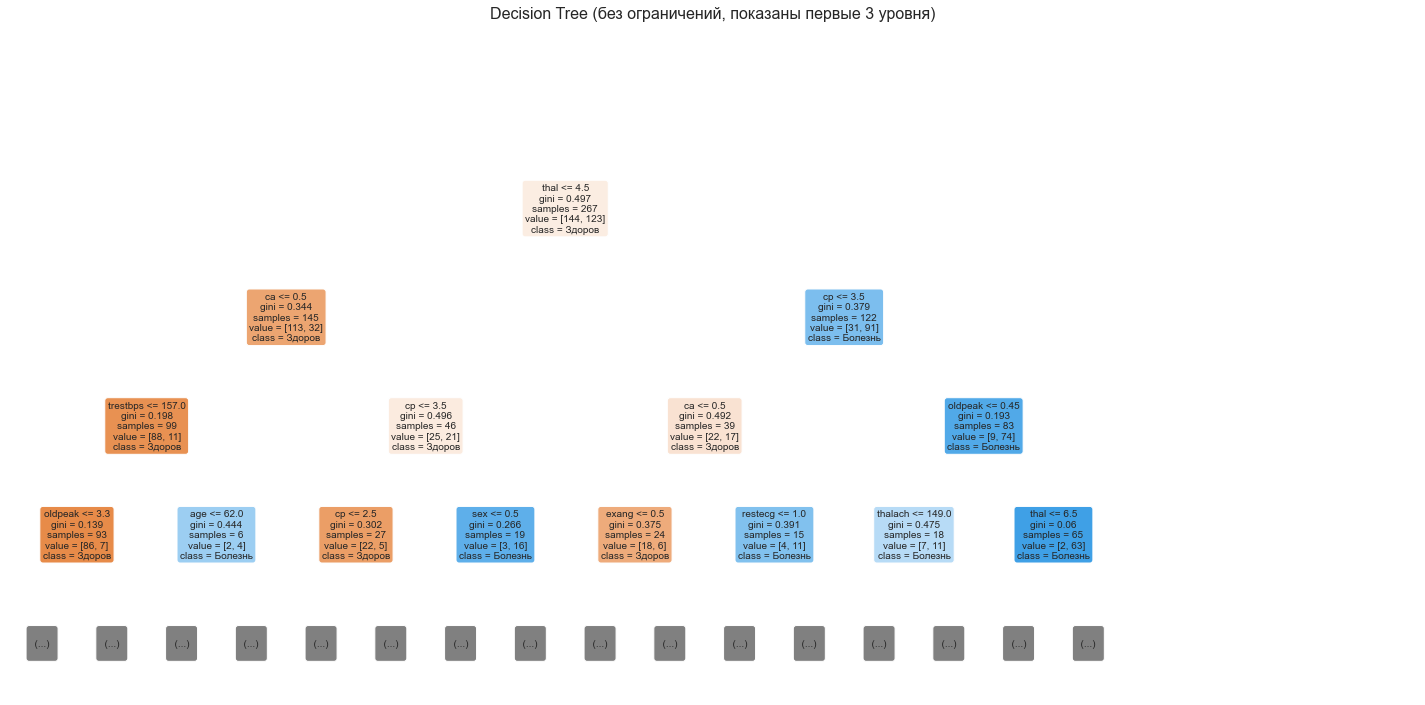

Полное дерево имеет 9 уровней!
На каждом листе в среднем 4.5 объектов.
Многие листья содержат всего 1-2 объекта → переобучение!


In [14]:
# Визуализация первых 3 уровней (всё дерево не влезет на экран)
plt.figure(figsize=(20, 10))
plot_tree(tree_deep, 
          max_depth=3,  # Показываем только 3 уровня
          feature_names=X.columns, 
          class_names=['Здоров', 'Болезнь'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree (без ограничений, показаны первые 3 уровня)', fontsize=16)
plt.tight_layout()
plt.show()

print(f"Полное дерево имеет {tree_deep.get_depth()} уровней!")
print(f"На каждом листе в среднем {212 / tree_deep.get_n_leaves():.1f} объектов.")
print("Многие листья содержат всего 1-2 объекта → переобучение!")

In [15]:
# Проверяем разные глубины
depths = [1, 2, 3, 5, 7, 10, 15, None]
results = []

for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    train_acc = tree.score(X_train, y_train)
    test_acc = tree.score(X_test, y_test)
    n_leaves = tree.get_n_leaves()
    
    results.append({
        'max_depth': depth if depth is not None else 'None',
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'Leaves': n_leaves
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

max_depth  Train Acc  Test Acc  Leaves
        1   0.764045  0.766667       2
        2   0.782772  0.666667       4
        3   0.865169  0.766667       8
        5   0.932584  0.700000      25
        7   0.981273  0.633333      42
       10   1.000000  0.666667      47
       15   1.000000  0.666667      47
     None   1.000000  0.666667      47


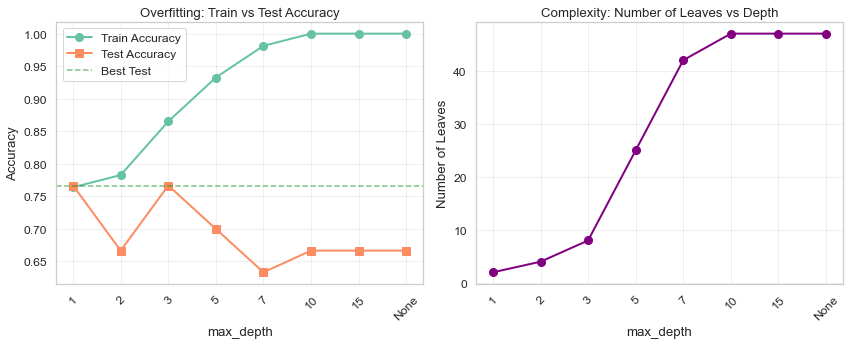

Анализ:
Лучший max_depth для test accuracy: 1
Test accuracy: 0.7667

При max_depth=None (без ограничений):
  Train: 1.0000
  Test:  0.6667
  Разрыв 33.3 п.п. = ПЕРЕОБУЧЕНИЕ


In [18]:
# График overfitting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
x_vals = [str(d) if d is not None else 'None' for d in depths]
plt.plot(x_vals, results_df['Train Acc'], 'o-', linewidth=2, markersize=8, label='Train Accuracy')
plt.plot(x_vals, results_df['Test Acc'], 's-', linewidth=2, markersize=8, label='Test Accuracy')
plt.axhline(results_df['Test Acc'].max(), color='green', linestyle='--', alpha=0.5, label='Best Test')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Overfitting: Train vs Test Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.plot(x_vals, results_df['Leaves'], 'o-', linewidth=2, markersize=8, color='purple')
plt.xlabel('max_depth')
plt.ylabel('Number of Leaves')
plt.title('Complexity: Number of Leaves vs Depth')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Анализ:")
best_idx = results_df['Test Acc'].idxmax()
print(f"Лучший max_depth для test accuracy: {results_df.loc[best_idx, 'max_depth']}")
print(f"Test accuracy: {results_df.loc[best_idx, 'Test Acc']:.4f}")
print(f"\nПри max_depth=None (без ограничений):")
print(f"  Train: {results_df[results_df['max_depth']=='None']['Train Acc'].values[0]:.4f}")
print(f"  Test:  {results_df[results_df['max_depth']=='None']['Test Acc'].values[0]:.4f}")
print(f"  Разрыв {(results_df[results_df['max_depth']=='None']['Train Acc'].values[0] - results_df[results_df['max_depth']=='None']['Test Acc'].values[0])*100:.1f} п.п. = ПЕРЕОБУЧЕНИЕ")

## Random Forest решает проблему переобучения через голосование многих деревьев.

In [33]:
# Обучаем Random Forest
rf = RandomForestClassifier(n_estimators=100,      # 100 деревьев
                            max_depth=None,         # Каждое дерево без ограничений!
                            random_state=42)
rf.fit(X_train, y_train)

# Предсказания
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest (100 деревьев, max_depth=None):")
print(f"  Train accuracy: {rf.score(X_train, y_train):.4f}")
print(f"  Test accuracy:  {acc_rf:.4f}")
print(f"Сравнение:")
print(f"Одно дерево (max_depth=None): Train=100%, Test=66%")
print(f"Random Forest (100 деревьев):  Train={rf.score(X_train, y_train):.1%}, Test={acc_rf:.1%}")
print(f"\nУлучшение test accuracy: {(acc_rf - results_df[results_df['max_depth']=='None']['Test Acc'].values[0])*100:+.1f} п.п.")

Random Forest (100 деревьев, max_depth=None):
  Train accuracy: 1.0000
  Test accuracy:  0.7333
Сравнение:
Одно дерево (max_depth=None): Train=100%, Test=66%
Random Forest (100 деревьев):  Train=100.0%, Test=73.3%

Улучшение test accuracy: +6.7 п.п.


In [34]:
# Извлечём предсказания отдельных деревьев
individual_preds = np.array([tree.predict(X_test) for tree in rf.estimators_[:10]])

# Для первых 5 примеров покажем, как деревья голосуют
print("Пример голосования (первые 5 объектов test):")
print("Obj | Реальный | Дерево1 | Дерево2 | Дерево3 | ... | Большинство | Правильно?")
print("-" * 80)

for i in range(5):
    votes = individual_preds[:, i]
    majority = int(np.round(votes.mean()))  # Большинство голосов
    correct = "+" if majority == y_test.iloc[i] else "-"
    
    print(f"{i:3} |    {y_test.iloc[i]}     | {votes[0]:7} | {votes[1]:7} | {votes[2]:7} | ... |     {majority}       |     {correct}")

print("Статистика голосования:")
# Для каждого объекта считаем процент деревьев, проголосовавших за класс 1
vote_probs = np.array([tree.predict_proba(X_test)[:, 1] for tree in rf.estimators_]).mean(axis=0)
print(f"Средняя вероятность класса 1 (первые 10 объектов): {vote_probs[:10]}")

Пример голосования (первые 5 объектов test):
Obj | Реальный | Дерево1 | Дерево2 | Дерево3 | ... | Большинство | Правильно?
--------------------------------------------------------------------------------
  0 |    0     |     0.0 |     0.0 |     0.0 | ... |     0       |     +
  1 |    0     |     0.0 |     1.0 |     0.0 | ... |     0       |     +
  2 |    0     |     0.0 |     0.0 |     0.0 | ... |     0       |     +
  3 |    1     |     0.0 |     0.0 |     0.0 | ... |     0       |     -
  4 |    0     |     0.0 |     0.0 |     0.0 | ... |     0       |     +
Статистика голосования:
Средняя вероятность класса 1 (первые 10 объектов): [0.04 0.08 0.56 0.19 0.06 0.72 0.54 0.12 0.4  0.76]


Сравнение важности признаков (топ-5):
 Feature  Importance RF  Importance Tree
      cp       0.137774         0.269634
 oldpeak       0.119722         0.047226
 thalach       0.113598         0.000000
    thal       0.108882         0.477426
      ca       0.108010         0.154217


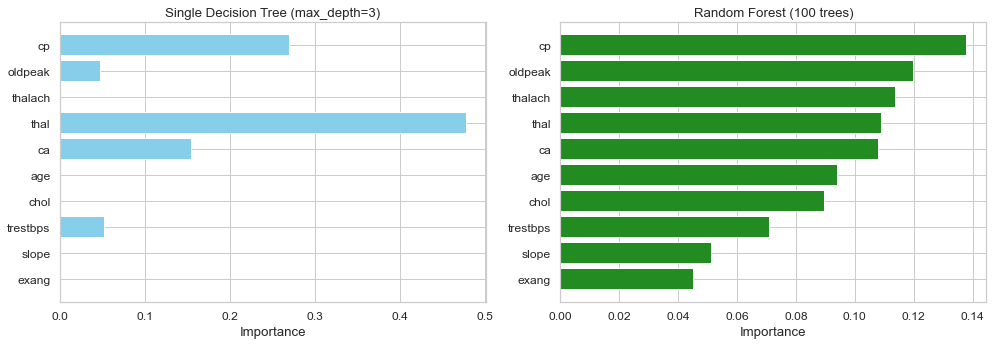

Наблюдения:
Random Forest распределяет важность более равномерно — использует больше признаков.
Single Tree фокусируется на топ-3 признаках.


In [35]:
# Важность признаков в Random Forest
importances_rf = rf.feature_importances_
feature_imp_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance RF': importances_rf,
    'Importance Tree': tree_simple.feature_importances_  # Для сравнения
}).sort_values('Importance RF', ascending=False)

print("Сравнение важности признаков (топ-5):")
print(feature_imp_rf.head().to_string(index=False))

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Single Tree
axes[0].barh(feature_imp_rf['Feature'][:10], feature_imp_rf['Importance Tree'][:10], color='skyblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Single Decision Tree (max_depth=3)')
axes[0].invert_yaxis()

# Random Forest
axes[1].barh(feature_imp_rf['Feature'][:10], feature_imp_rf['Importance RF'][:10], color='forestgreen')
axes[1].set_xlabel('Importance')
axes[1].set_title('Random Forest (100 trees)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("Наблюдения:")
print("Random Forest распределяет важность более равномерно — использует больше признаков.")
print("Single Tree фокусируется на топ-3 признаках.")

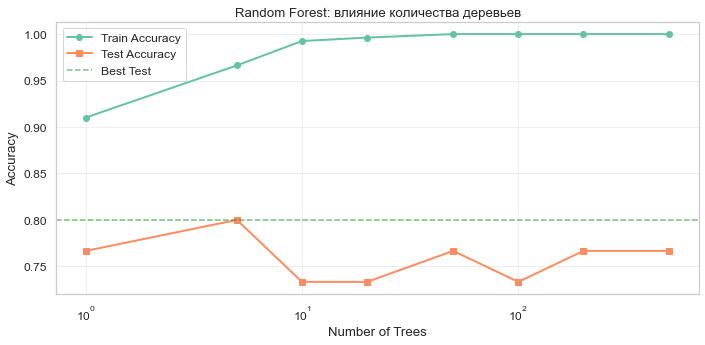

Оптимальное количество деревьев: 5
Test accuracy: 0.8000
После 5 деревьев улучшение минимально → не стоит увеличивать дальше.


In [38]:
# Как количество деревьев влияет на accuracy?
n_trees_list = [1, 5, 10, 20, 50, 100, 200, 500]
train_scores = []
test_scores = []

for n in n_trees_list:
    rf_temp = RandomForestClassifier(n_estimators=n, max_depth=None, random_state=42)
    rf_temp.fit(X_train, y_train)
    train_scores.append(rf_temp.score(X_train, y_train))
    test_scores.append(rf_temp.score(X_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(n_trees_list, train_scores, 'o-', linewidth=2, label='Train Accuracy')
plt.plot(n_trees_list, test_scores, 's-', linewidth=2, label='Test Accuracy')
plt.axhline(max(test_scores), color='green', linestyle='--', alpha=0.5, label='Best Test')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest: влияние количества деревьев')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')  # Логарифмическая шкала для наглядности
plt.tight_layout()
plt.show()

print(f"Оптимальное количество деревьев: {n_trees_list[np.argmax(test_scores)]}")
print(f"Test accuracy: {max(test_scores):.4f}")
print("После 5 деревьев улучшение минимально → не стоит увеличивать дальше.")

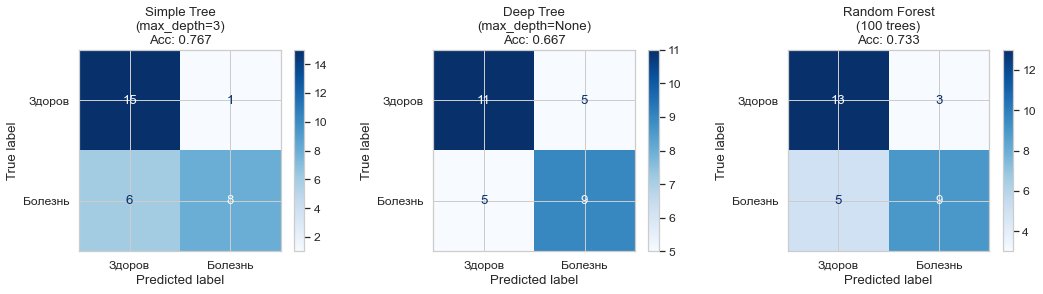

In [39]:
# Сравнение confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models = [
    ('Simple Tree\n(max_depth=3)', tree_simple, y_pred_simple),
    ('Deep Tree\n(max_depth=None)', tree_deep, y_pred_deep),
    ('Random Forest\n(100 trees)', rf, y_pred_rf)
]

for i, (name, model, y_pred) in enumerate(models):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Здоров', 'Болезнь'])
    disp.plot(ax=axes[i], cmap='Blues', values_format='d')
    axes[i].set_title(f'{name}\nAcc: {accuracy_score(y_test, y_pred):.3f}')

plt.tight_layout()
plt.show()

In [41]:
# Cross-validation для честной оценки
from sklearn.model_selection import cross_val_score

models_cv = [
    ('Simple Tree (depth=3)', DecisionTreeClassifier(max_depth=3, random_state=42)),
    ('Deep Tree (no limit)', DecisionTreeClassifier(random_state=42)),
    ('Random Forest (100)', RandomForestClassifier(n_estimators=100, random_state=42))
]

print("5-Fold Cross-Validation:")
print("-" * 60)

for name, model in models_cv:
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{name:25s}: {scores.mean():.4f} ± {scores.std():.4f}")
    print(f"  Scores по фолдам: {scores}")

print("\ Random Forest наиболее стабилен (низкий std) → лучше обобщает.")

5-Fold Cross-Validation:
------------------------------------------------------------
Simple Tree (depth=3)    : 0.7945 ± 0.0603
  Scores по фолдам: [0.71666667 0.9        0.79661017 0.76271186 0.79661017]
Deep Tree (no limit)     : 0.7539 ± 0.0569
  Scores по фолдам: [0.73333333 0.86666667 0.72881356 0.71186441 0.72881356]
Random Forest (100)      : 0.8078 ± 0.0376
  Scores по фолдам: [0.83333333 0.86666667 0.77966102 0.76271186 0.79661017]
\ Random Forest наиболее стабилен (низкий std) → лучше обобщает.
